In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report, auc
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier

- | PRG           | Attribute1       |  Plasma glucose level

- | PL               | Attribute 2     |   Blood Work Result-1 (mu U/ml)                                                                                                                                               
- | PR              | Attribute 3      | Blood Pressure (mmHg )    

- | SK              | Attribute 4      | Blood Work Result-2 (mm) 

- | TS             | Attribute 5      |     Blood Work Result-3 (mu U/ml)
                                                                                               
- | M11     | Attribute 6    |  Body mass index (weight in kg/(height in m))^2

- | BD2             | Attribute 7     |   Blood Work Result-4 (mu U/ml)                                                                                                                                               
- | Age              | Attribute 8      |    patients age  (years)                                                                                                                                          

- | Sepssis                 | Target           | Positive: if a patient in ICU will 
develop a sepsis , and Negative: otherwise |


# First, open the csv file 

In [2]:
test = pd.read_csv('Paitients_Files_Test.csv')
train = pd.read_csv('Paitients_Files_Train.csv')
train.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [3]:
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")                 

Train data shape: (599, 11)
Test data shape: (169, 10)


# EDA - Exploratory Data Analysis and data preprocessing 

In [4]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


- The TS and PL columns seems to have many outliers and the mean between two models are quite difference
- No missing values. However, I check it again below 
standard deviation in TS column is large 

In [5]:
print(train.info(),'\n')
print(train.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB
None 

ID            object
PRG            int64
PL             int64
PR             int64
SK             int64
TS             int64
M11          float64
BD2          float64
Age            int64
Insurance      int64
Sepssis       object
dtype: object


In [6]:
train.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [7]:
#rename sepssis
train.rename(columns={'Sepssis':'Sepsis'}, inplace=True)

- The sepssis columns contain typos error 

In [8]:
X= train.iloc[:,1:-1]
y = train.iloc[:,-1].map({'Positive':1,'Negative':0})
features = X.columns
X.shape, y.shape

((599, 9), (599,))

- divided the train dataset into X(features) and y(target variable)

In [9]:
X = train.drop(['ID','Insurance','Sepsis'], axis = 1)

- drop unsuitable columns 

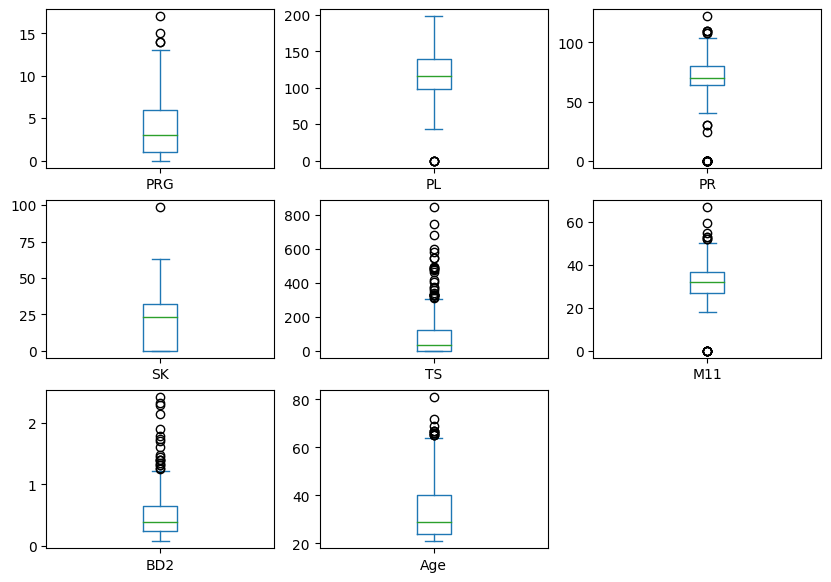

In [10]:
X.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (10, 7))
plt.show()

- after plotting the boxplot, We can see that there are numerous outliers in TS and BD2, let's check how many outliers it is contain 

In [11]:
def find_outliers(data):
    # Calculate the interquartile range (IQR)
    for col in list(data.columns):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count the number of outliers
        num_outliers = len(data[(data[col] < lower_bound) | (data[col] > upper_bound)])
        print(f"{col} has {num_outliers} outliers")
    
find_outliers(X)

PRG has 4 outliers
PL has 5 outliers
PR has 37 outliers
SK has 1 outliers
TS has 28 outliers
M11 has 16 outliers
BD2 has 19 outliers
Age has 12 outliers


- we will work will the outliers later. But first, we need to check the model's distribution 

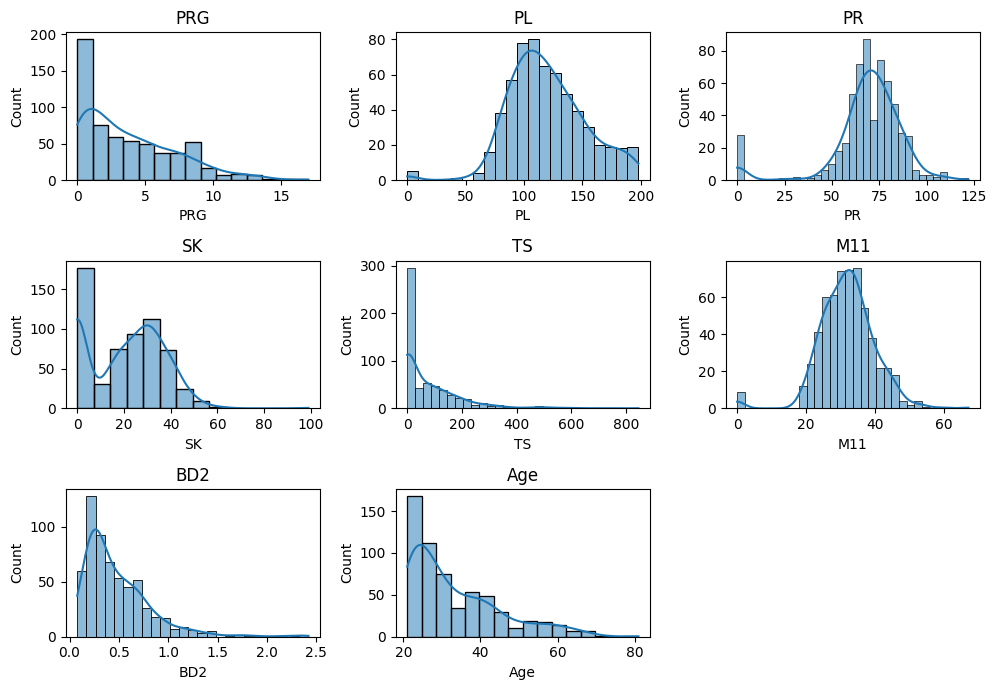

In [12]:
#check the distribution  of the data
def check_distribution(data):
    plt.figure(figsize=(10, 7))
    for i, col in enumerate(data.columns):
        plt.subplot(3, 3, i+1)
        sns.histplot(data[col], kde=True)
        plt.title(col)
    plt.tight_layout()
    plt.show()
check_distribution(X)

- Using logarit to re-skew the dataset to get the bell shape - normal distribution

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


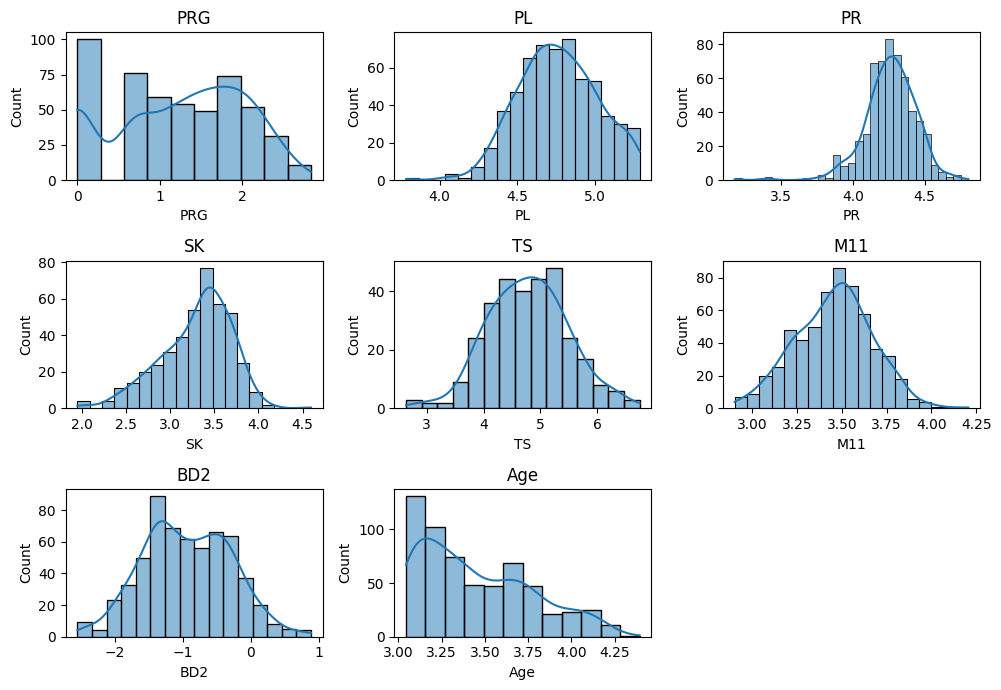

In [13]:
def re_distribute(data):
    for col in list(data.columns):
        data[col] = np.log(data[col])
    return data
re_distribute(X)
check_distribution(X)

- Since the columns PRG, Age and BD2 are not in the bell-shape distribution, I will apply quantile
- quantile helps us to get how many values above or below limit 
- replace outliers with the normal range(25--75)

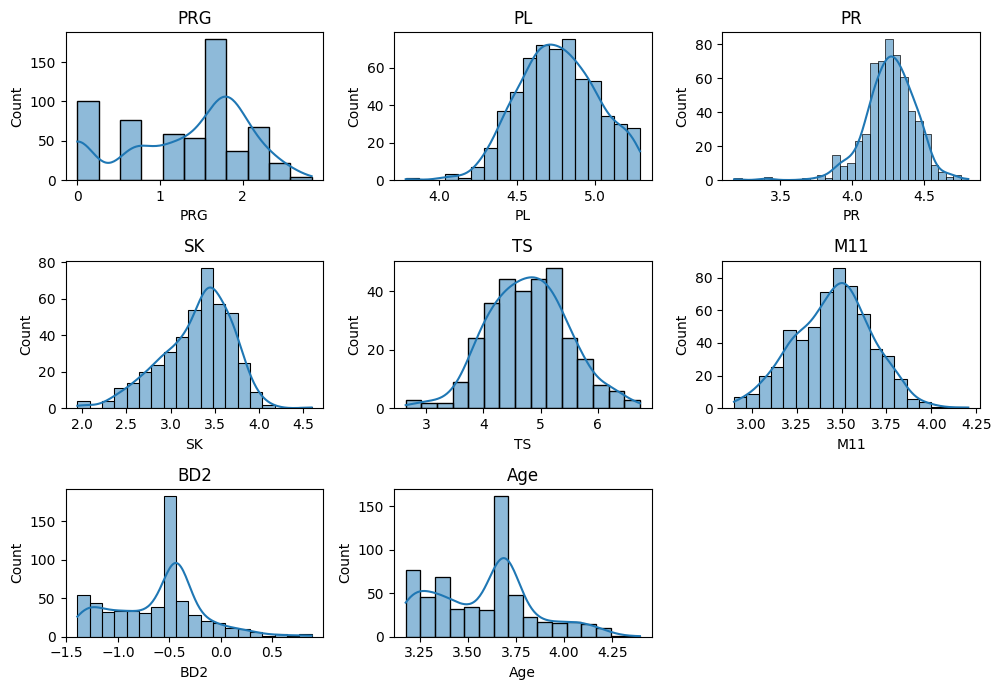

In [14]:
X["PRG"] = np.where(X["PRG"] < X["PRG"].quantile(0.25), X["PRG"].quantile(0.75), X["PRG"])
X["Age"] = np.where(X["Age"] < X["Age"].quantile(0.25), X["Age"].quantile(0.75), X["Age"])
X["BD2"] = np.where(X["BD2"] < X["BD2"].quantile(0.25), X["BD2"].quantile(0.75), X["BD2"])
check_distribution(X)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15620\86519417.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = train.corr()


Text(0.5, 1.0, 'Correlation Matrix of Data')

<Figure size 900x800 with 0 Axes>

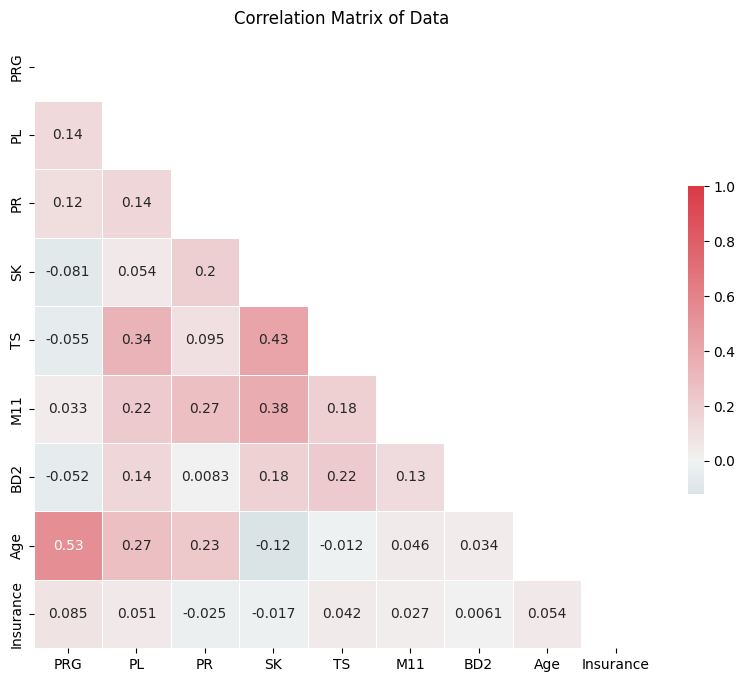

In [15]:
plt.figure(figsize= (9,8))
cor = train.corr() 
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(cor, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .5}, annot = True)
ax.set_title('Correlation Matrix of Data')

In [16]:
# Concatenate X and y into a single DataFrame
reTrain = pd.concat([X, y], axis=1)

# Separate the minority and majority classes
major = reTrain[reTrain['Sepsis'] == 0]
minor = reTrain[reTrain['Sepsis'] == 1]

# Upsample the minority class
upsample = resample(minor,
                    replace=True,     # sample with replacement
                    n_samples=391)    # to match minority class count

# Combine majority class with upsampled minority class
upsampled_data = pd.concat([major, upsample])

# Separate the feature matrix X and target variable y
upsampled_X = upsampled_data.iloc[:, :-1]
upsampled_y = upsampled_data.iloc[:, -1]
print("New shape of the dataset:", upsampled_X.shape, upsampled_y.shape)
upsampled_y.value_counts()

New shape of the dataset: (782, 8) (782,)


0    391
1    391
Name: Sepsis, dtype: int64

- working with the imbalanced class - upsample negative values 
- prevent the model from subjecting to positive 

In [17]:
#replace inf values with nan
upsampled_X.replace([np.inf, -np.inf], np.nan, inplace=True)
#reoplace Nan by mean + 2std
upsampled_X.fillna(upsampled_X.mean(), inplace=True)

- Since the infinity values are rejected in modelling, I filled all of it with the mean of the dataset

# Modelling:
##### split the above upsampled X and Y variables into Xtrain, Xtest, ytrain, ytest

In [18]:
#split the data into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(upsampled_X, upsampled_y, test_size = 0.2, random_state = 42)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((625, 8), (157, 8), (625,), (157,))

- shapes are fine. Let's start with modelling process

Logistic Regression Results:
Training Accuracy: 0.728
Testing Accuracy: 0.7261146496815286
Training Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73       308
           1       0.74      0.72      0.73       317

    accuracy                           0.73       625
   macro avg       0.73      0.73      0.73       625
weighted avg       0.73      0.73      0.73       625

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75        83
           1       0.72      0.68      0.70        74

    accuracy                           0.73       157
   macro avg       0.73      0.72      0.72       157
weighted avg       0.73      0.73      0.73       157

Training Confusion Matrix:
 [[228  80]
 [ 90 227]]
Testing Confusion Matrix:
 [[64 19]
 [24 50]]
-----------------------------
Decision Tree Results:
Training Accuracy: 1.0
Testing Accuracy:

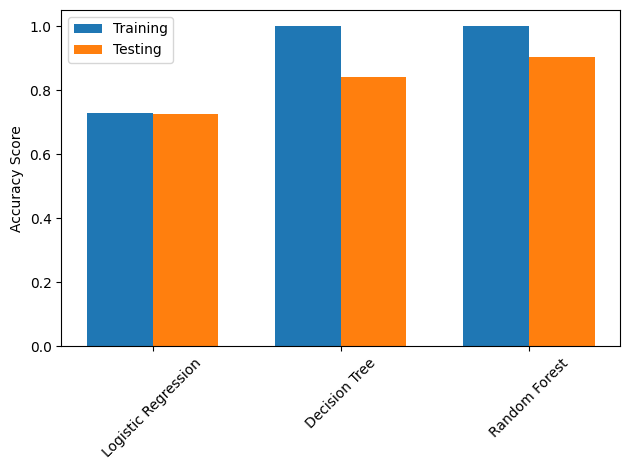

In [37]:
# define a function to train and evaluate the models
def train_and_evaluate(model):
    # fit the model on the training data then make predictions
    model.fit(Xtrain, ytrain)
    
    train_preds = model.predict(Xtrain)
    test_preds = model.predict(Xtest)
    
    # calculate accuracy scores
    train_acc = accuracy_score(ytrain, train_preds)
    test_acc = accuracy_score(ytest, test_preds)
    # generate classification reports and confusion matrices
    train_report = classification_report(ytrain, train_preds)
    test_report = classification_report(ytest, test_preds)
    train_confusion = confusion_matrix(ytrain, train_preds)
    test_confusion = confusion_matrix(ytest, test_preds)
    
    return train_acc, test_acc, train_report, test_report, train_confusion, test_confusion
    
# define the models
lr = LogisticRegression(max_iter=1000)
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()



# train and evaluate each model
lr_train_acc, lr_test_acc, lr_train_report, lr_test_report, lr_train_cm, lr_test_cm = train_and_evaluate(lr)
dt_train_acc, dt_test_acc, dt_train_report, dt_test_report, dt_train_cm, dt_test_cm = train_and_evaluate(tree)
rf_train_acc, rf_test_acc, rf_train_report, rf_test_report, rf_train_cm, rf_test_cm = train_and_evaluate(rf)


# print the results for each model
print("Logistic Regression Results:")
print("Training Accuracy:", lr_train_acc)
print("Testing Accuracy:", lr_test_acc)
print("Training Classification Report:\n", lr_train_report)
print("Testing Classification Report:\n", lr_test_report)
print("Training Confusion Matrix:\n", lr_train_cm)
print("Testing Confusion Matrix:\n", lr_test_cm)
print("-----------------------------")

# print("K-Nearest Neighbors Results:")
# print("Training Accuracy:", knn_train_acc)
# print("Testing Accuracy:", knn_test_acc)
# print("Training Classification Report:\n", knn_train_report)
# print("Testing Classification Report:\n", knn_test_report)
# print("Training Confusion Matrix:\n", knn_train_cm)
# print("Testing Confusion Matrix:\n", knn_test_cm)
# print("-----------------------------")

# print("Support Vector Machine Results:")
# print("Training Accuracy:", svc_train_acc)
# print("Testing Accuracy:", svc_test_acc)
# print("Training Classification Report:\n", svc_train_report)
# print("Testing Classification Report:\n", svc_test_report)
# print("Training Confusion Matrix:\n", svc_train_cm)
# print("Testing Confusion Matrix:\n", svc_test_cm)
# print("-----------------------------")

print("Decision Tree Results:")
print("Training Accuracy:", dt_train_acc)
print("Testing Accuracy:", dt_test_acc)
print("Training Classification Report:\n", dt_train_report)
print("Testing Classification Report:\n", dt_test_report)
print("Training Confusion Matrix:\n", dt_train_cm)
print("Testing Confusion Matrix:\n", dt_test_cm)
print("-----------------------------")

print("Random Forest Results:")
print("Training Accuracy:", rf_train_acc)
print("Testing Accuracy:", rf_test_acc)
print("Training Classification Report:\n", rf_train_report)
print("Testing Classification Report:\n", rf_test_report)
print("Training Confusion Matrix:\n", rf_train_cm)
print("Testing Confusion Matrix:\n", rf_test_cm)
print("-----------------------------")

# plot a chart to show the differences between the models
# labels = ['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest']
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest']
# train_accs = [lr_train_acc, knn_train_acc, svc_train_acc, dt_train_acc, rf_train_acc]
# test_accs = [lr_test_acc, knn_test_acc, svc_test_acc, dt_test_acc, rf_test_acc]
train_acc = [lr_train_acc, dt_train_acc, rf_train_acc]
test_acc = [lr_test_acc, dt_test_acc, rf_test_acc]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_acc, width, label='Training')
rects2 = ax.bar(x + width/2, test_acc, width, label='Testing')

ax.set_ylabel('Accuracy Score')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


- It seems that Decision Tree issues overfitting so let's work with it. However, Logistic regression is the best model since the accuracy 
- in train and test set quite well

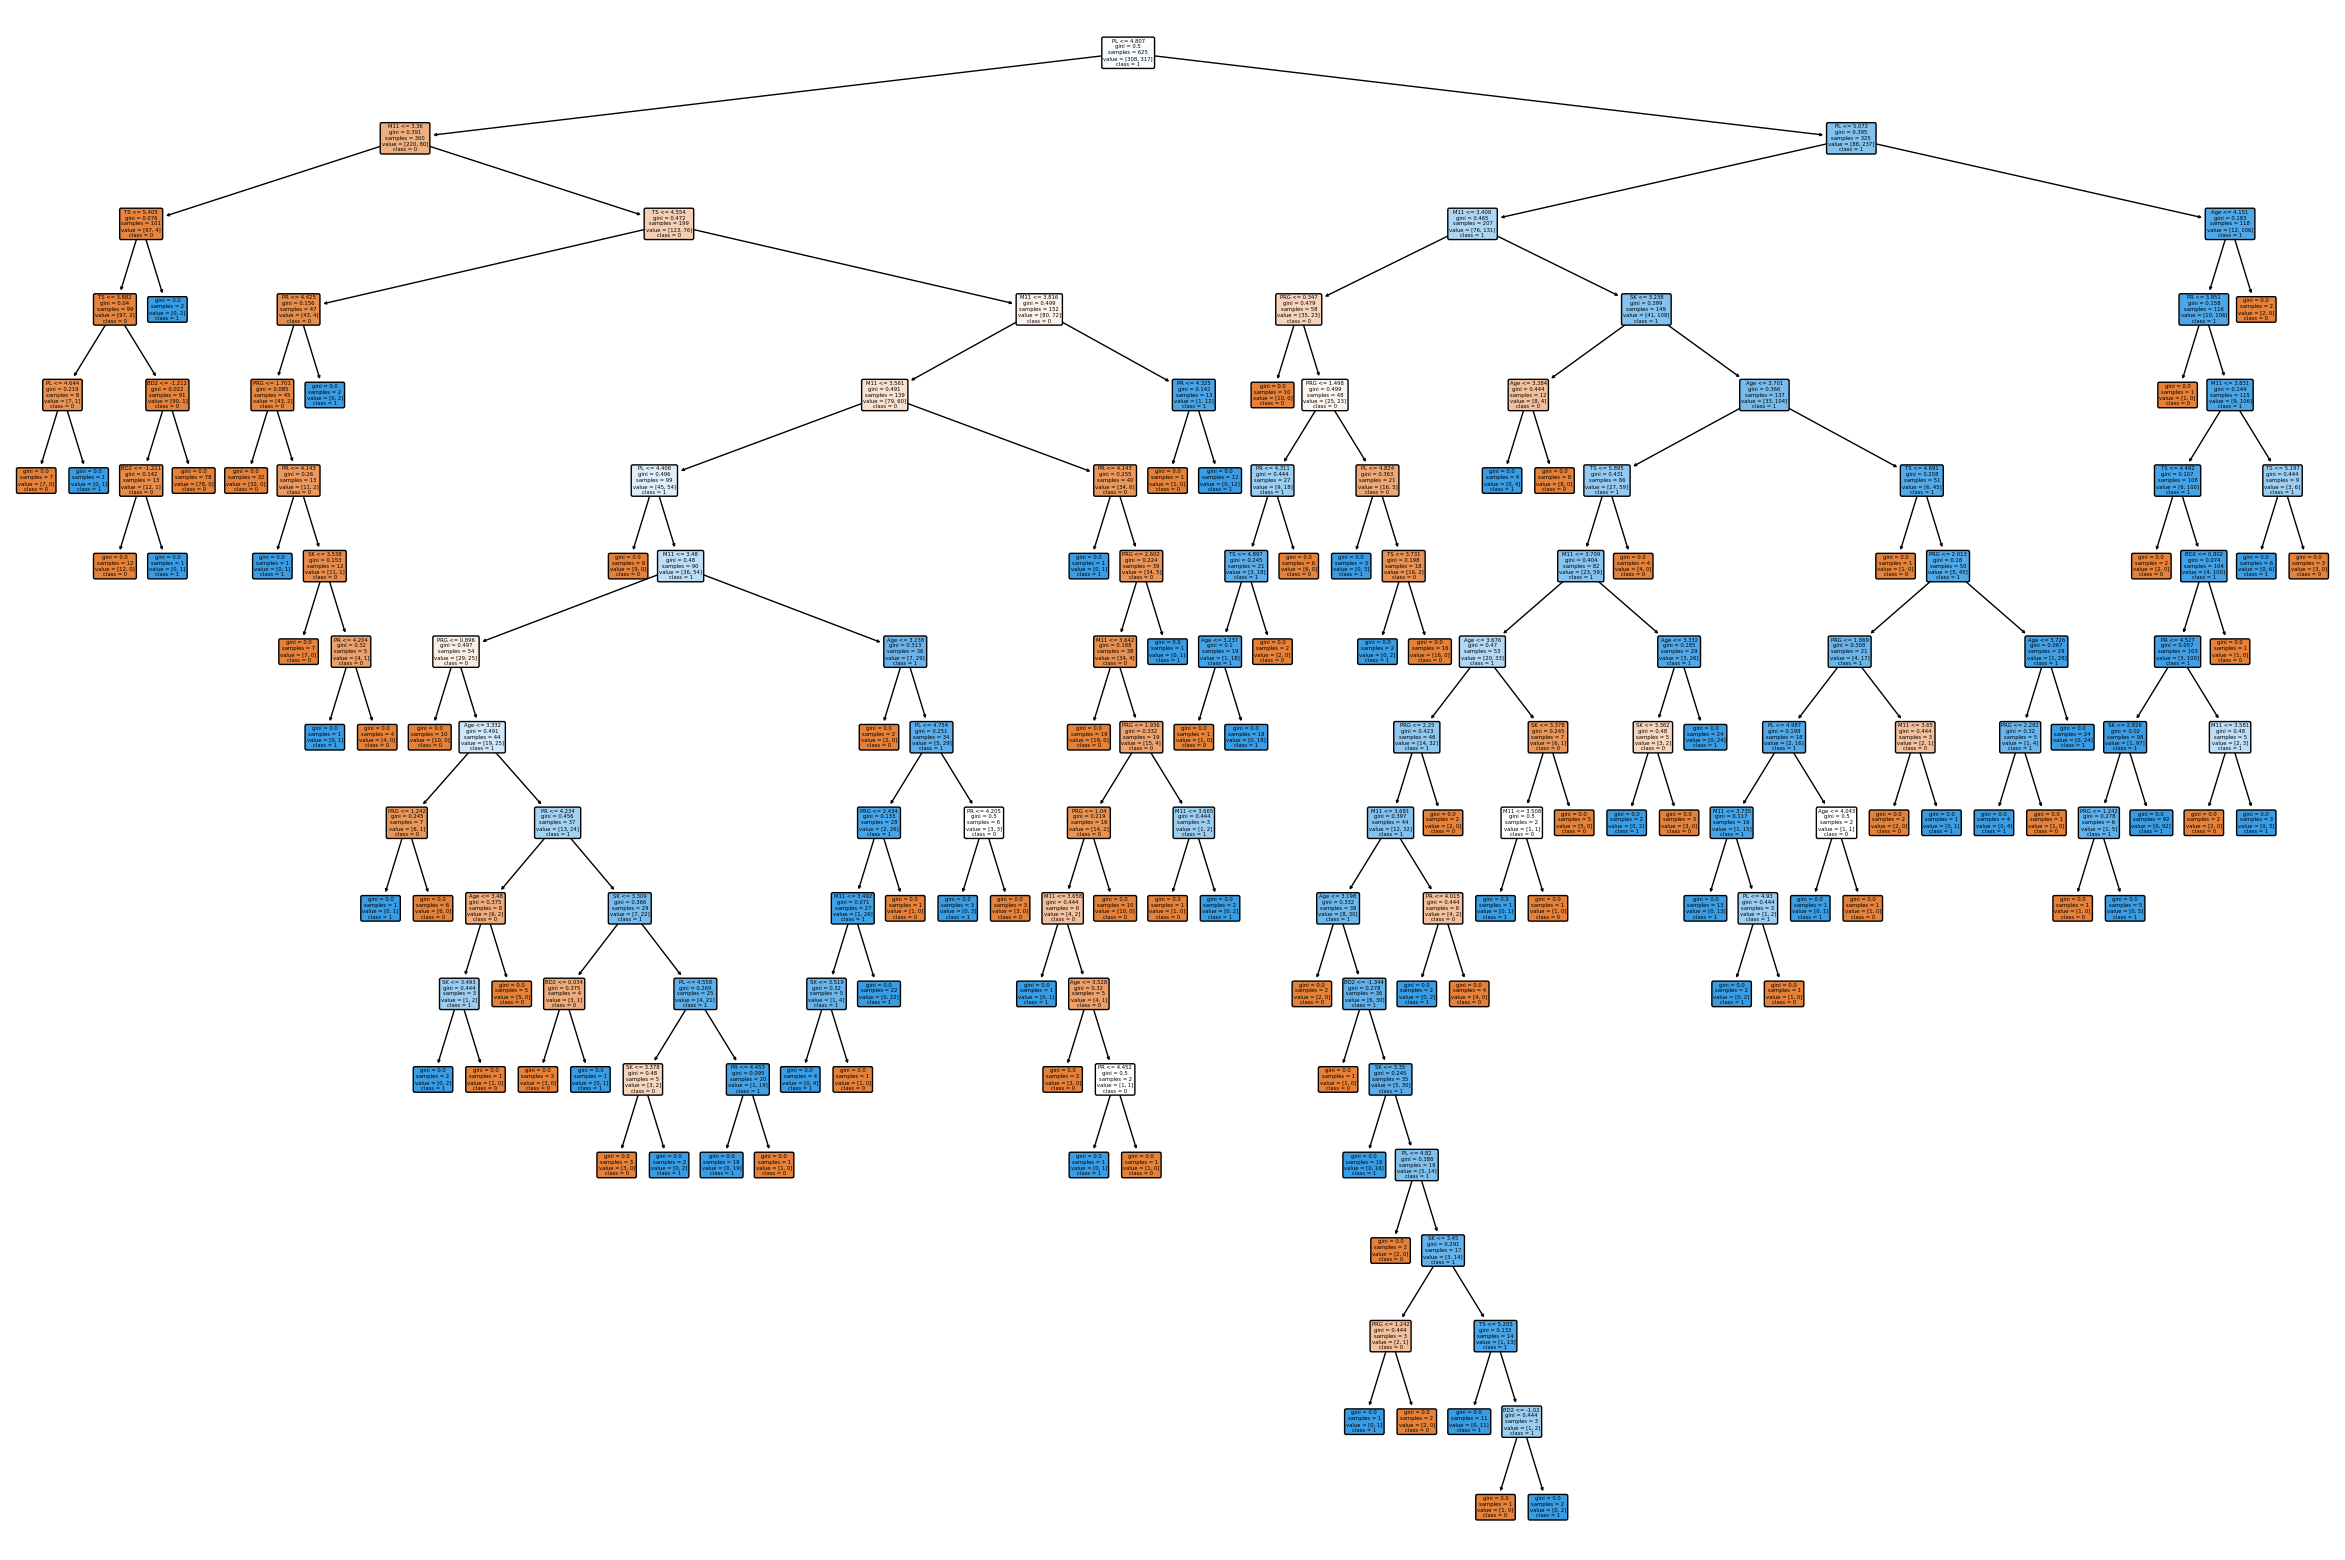

In [20]:
tree = DecisionTreeClassifier()
tree.fit(Xtrain, ytrain)
ytrainPred = tree.predict(Xtrain)
ytestPred = tree.predict(Xtest)
plt.figure(figsize=(30,20))
plot_tree(tree, filled=True, rounded=True, class_names=['0','1'], feature_names=(["PRG","PL","PR","SK","TS","M11","BD2","Age"]))
plt.show()

- plotting the tree. We can see that it's very complex

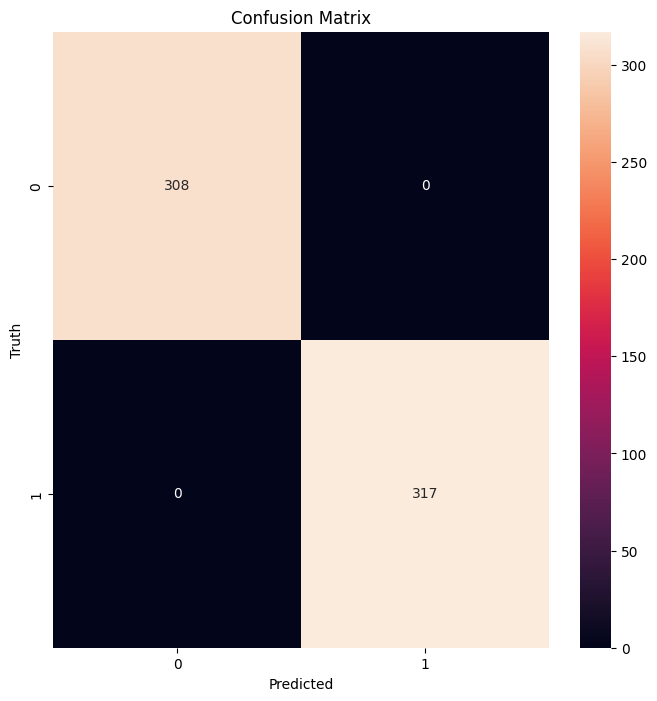

Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       308
           1       1.00      1.00      1.00       317

    accuracy                           1.00       625
   macro avg       1.00      1.00      1.00       625
weighted avg       1.00      1.00      1.00       625



In [21]:
def plotMaxtrix(ytrainPred, ytrain, dom):
    cm = confusion_matrix(ytrain, ytrainPred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    print(dom)
    print(classification_report(ytrain, ytrainPred))
    
plotMaxtrix(ytrainPred, ytrain, 'Train')

yeah, overfit. 
- So we should prune the tree to find the best parameters 
- using grid search to search for the best param
- some rules: min_sample_split > min_samples_leaf 
- set the range from 1 to 20
- I meant I pass everything into grid search cv 

In [22]:
# grid search CV to find the best parameters
params = {
    "max_depth": range(1,12),
    "min_samples_split": range(2,20),
    "min_samples_leaf": range(1,20),
    "criterion": ("gini", "entropy", "log_loss"),
    "splitter": ("best", "random"),
}
tree2 = DecisionTreeClassifier()
grid = GridSearchCV(estimator=tree2, param_grid=params)
grid.fit(Xtrain, ytrain)
print("best params:", grid.best_params_)

best params: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


- so we received some of the best parameter of the tree. 
- However, there are some more such as __max+leaf_node__. Let's discover them 

In [23]:
#function to find max_leaf_node 
def find_max_leaf_node(Xtrain, ytrain):
    max_leaf_nodes = []
    # loop through the range of 2 to 100
    for i in range(2, 100):
        tree = DecisionTreeClassifier(max_leaf_nodes=i, random_state=0)
        tree.fit(Xtrain, ytrain)
        max_leaf_nodes.append(tree.tree_.node_count)
    return max_leaf_nodes
max_leaf_node = find_max_leaf_node(Xtrain, ytrain)
print(max(max_leaf_node))

189


In [24]:
model = grid.best_estimator_
print(grid.best_params_)
model.fit(Xtrain, ytrain)
print("train score: ", model.score(Xtrain, ytrain))
print("test score: ", model.score(Xtest, ytest))

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
train score:  0.9392
test score:  0.7898089171974523


- we can see that, with those parameters, the model seems to be fluctuate, So I will continue to find the best ccp-alpha parameter

In [25]:
path = model.cost_complexity_pruning_path(Xtrain, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("CCP Alphas: ", ccp_alphas)
print("Impurities: ", impurities)

clfs = []
for ccp_alpha in ccp_alphas:
    tree3 = DecisionTreeClassifier(random_state=420, ccp_alpha=ccp_alpha)
    tree3.fit(Xtrain, ytrain)
    clfs.append(tree3)

CCP Alphas:  [0.         0.00050068 0.00108889 0.00114286 0.00146667 0.00154483
 0.00156768 0.00159111 0.00185965 0.00187382 0.00243368 0.00254118
 0.0029042  0.00295385 0.00303158 0.00304678 0.00323794 0.00384
 0.00423342 0.00439739 0.0047669  0.00481881 0.00517684 0.00525354
 0.00541538 0.00559508 0.00602236 0.00672    0.00731171 0.00746724
 0.00826505 0.00942545 0.01172193 0.0143974  0.01694729 0.0173458
 0.02512067 0.1068116 ]
Impurities:  [0.08499677 0.08549745 0.08658634 0.0877292  0.09066253 0.09375219
 0.10002289 0.10320511 0.10692441 0.11254587 0.11741324 0.11995441
 0.12285862 0.12581246 0.12884404 0.13798439 0.14122233 0.14506233
 0.16199602 0.1663934  0.1711603  0.17597911 0.19668647 0.20194001
 0.20735539 0.21295047 0.21897284 0.22569284 0.25493966 0.26987415
 0.28640425 0.2958297  0.31927356 0.33367096 0.35061825 0.36796405
 0.39308472 0.49989632]


- plot the model prediction to find the best ccp-alpha range 
- the best cpp-alpha is between 0,06 to 0,1 
- and best alpha for best train are somewhere around 0,0005

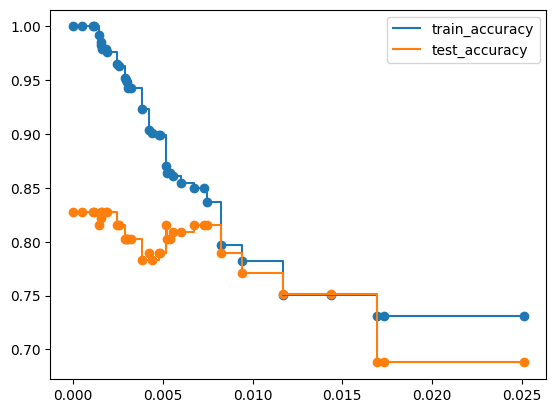

In [36]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(Xtrain)
    y_test_pred = c.predict(Xtest)
    train_acc.append(accuracy_score(y_train_pred,ytrain))
    test_acc.append(accuracy_score(y_test_pred,ytest))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.show()

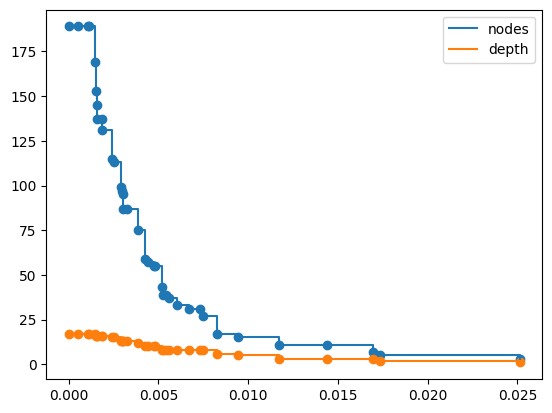

In [27]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

 - based on the list of alpha above, 

best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
max_leaf_nodes = 197
ccp_alphas = 0.00050909 
- build a new tree from those params 

In [28]:
LastTree = DecisionTreeClassifier(ccp_alpha=0.00050909,          
                                  max_depth=10, 
                                  criterion='gini',
                                  splitter='best',
                                  min_samples_leaf= 2,
                                  min_samples_split= 5,
                                  max_leaf_nodes=197,
                                  )

LastTree.fit(Xtrain, ytrain)
LasTrainPred= LastTree.predict(Xtrain)
LastTestPred= LastTree.predict(Xtest)
print("Train report:\n", classification_report(ytrain, LasTrainPred))
print("Accuracy score train: ", accuracy_score(ytrain, LasTrainPred))
print("Test report:\n", classification_report(ytest, LastTestPred))
print("Accuracy score test: ", accuracy_score(ytest, LastTestPred))

Train report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       308
           1       0.94      0.96      0.95       317

    accuracy                           0.95       625
   macro avg       0.95      0.95      0.95       625
weighted avg       0.95      0.95      0.95       625

Accuracy score train:  0.9472
Test report:
               precision    recall  f1-score   support

           0       0.86      0.76      0.81        83
           1       0.76      0.86      0.81        74

    accuracy                           0.81       157
   macro avg       0.81      0.81      0.81       157
weighted avg       0.82      0.81      0.81       157

Accuracy score test:  0.8089171974522293


- visual the accuracy ROC-AUC score 

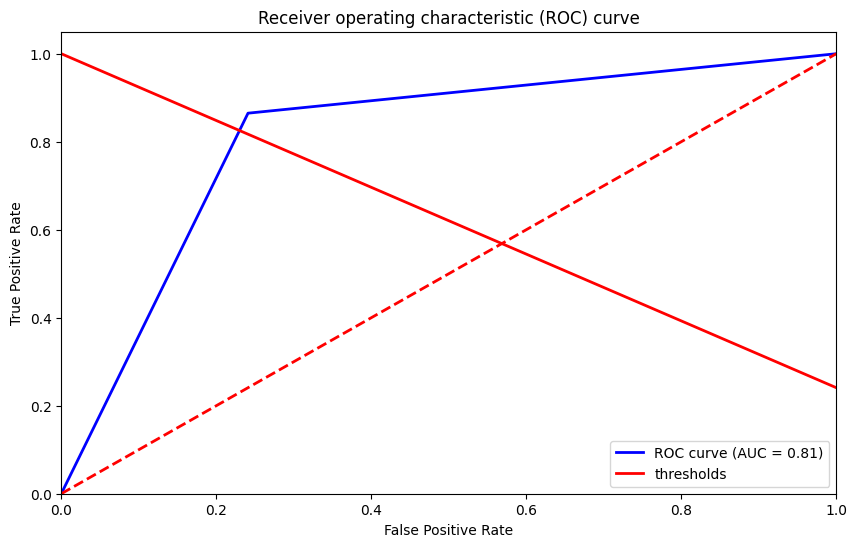

AUC:  0.811950504721589


In [29]:
yScores = LastTree.predict_proba(Xtest)[:,1]
def plot_ROC(yTrue, yScores):
    # Calculate the false positive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(yTrue, yScores)
    # Calculate the AUC score
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot(thresholds, fpr, color='r', lw=2, label='thresholds')
    plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: ", roc_auc)
plot_ROC(ytest, LastTestPred)

- try with random forest to see if the performance is better 

In [30]:
#random Forest
rf = RandomForestClassifier(ccp_alpha=0.00050909,          
                                  max_depth=10, 
                                  criterion='gini',
                                  min_samples_leaf= 2,
                                  min_samples_split= 5,
                                  max_leaf_nodes=197,
                                  )


rf.fit(Xtrain, ytrain)
rf_train_pred= rf.predict(Xtrain)
rf_test_pred= rf.predict(Xtest)
print("report on train set:\n",classification_report(ytrain, rf_train_pred))
print("Accuracy score train: ", accuracy_score(ytrain, rf_train_pred))
print("report on test set:\n",classification_report(ytest, rf_test_pred))
print("Accuracy score test: ", accuracy_score(ytest, rf_test_pred))

report on train set:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       308
           1       0.95      0.97      0.96       317

    accuracy                           0.96       625
   macro avg       0.96      0.96      0.96       625
weighted avg       0.96      0.96      0.96       625

Accuracy score train:  0.9616
report on test set:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86        83
           1       0.82      0.89      0.86        74

    accuracy                           0.86       157
   macro avg       0.86      0.86      0.86       157
weighted avg       0.86      0.86      0.86       157

Accuracy score test:  0.8598726114649682


- it's better, then I will choose Random Forest to get the las prediction. 

In [31]:
bipdata = test 
bipdata.head()
bipdata.shape

(169, 10)

In [32]:
bipdata = test.drop(['ID', "Insurance"], axis= 1)

In [33]:
ybip = rf.predict(bipdata)  

In [34]:
bipdata['Sepsis'] = ybip
bipdata.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
0,1,109,38,18,120,23.1,0.407,26,1
1,1,108,88,19,0,27.1,0.400,24,1
2,6,96,0,0,0,23.7,0.190,28,1
3,1,124,74,36,0,27.8,0.100,30,1
4,7,150,78,29,126,35.2,0.692,54,1


In [35]:
predict = pd.DataFrame ({
    "ID": test["ID"],
    "Sepsis": bipdata["Sepsis"].map({0: "Negative", 1: "Positive"})
})
finalPred = predict.to_csv("s3877256_prediction.csv", index=False)
